### Import Dependencies:

conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

conda install -c fastai fastai

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *

# Collaborative Filtering Book Recommendation System Using Deep Learning

### Import and Process the Book Data:

### Import Data:

In [ ]:
import pandas as pd
ratings = pd.read_csv('Ratings.csv')
books = pd.read_csv('Books.csv', dtype={3: 'str'})

### Process the Data:

Merge ratings dataframe with the books dataframe and remove unnecessary columns:

In [ ]:
ratings_books_df = ratings.merge(books, on='ISBN')
ratings_books_df.drop(columns=['ISBN', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
ratings_books_df.columns = ['user', 'rating', 'title']
ratings_books_df.head()

,user,rating,title
0,276725,0,Flesh Tones: A Novel
1,2313,5,Flesh Tones: A Novel
2,6543,0,Flesh Tones: A Novel
3,8680,5,Flesh Tones: A Novel
4,10314,9,Flesh Tones: A Novel


Filter the Data:

In [ ]:
# Remove all ratings with 0.
ratings_books_df = ratings_books_df[ratings_books_df['rating'] > 0]

# Set thresholds for the number of ratings a user has given and the number of ratings a book has.
min_ratings_user = 100
min_ratings_book = 100

# Filters the dataframe to only include rows with users that have rated at least min_ratings_user books.
users_with_min_ratings = ratings_books_df.groupby('user').filter(lambda x: len(x) >= min_ratings_user)

# Filters the dataframe to only include movies with at least min_ratings_book ratings.
books_with_min_ratings = ratings_books_df.groupby('title').filter(lambda x: len(x) >= min_ratings_book)

# Filters the dataframe to include the correct data.
filtered_df = users_with_min_ratings[users_with_min_ratings['title'].isin(books_with_min_ratings['title'])]

filtered_df.head()

,user,rating,title
69,11676,10,The Notebook
74,23768,6,The Notebook
81,30711,6,The Notebook
124,158295,8,The Notebook
132,185233,7,The Notebook


### Create a DataLoader Using the Data:

In [ ]:
# Dataloaders - Set seed to 42 for consistent results
dls = CollabDataLoaders.from_df(filtered_df, item_name='title', rating_name='rating', bs=64, seed=42)
dls.show_batch()

,user,title,rating
0,265889,The Reader,8
1,35857,Congo,7
2,230522,The Giver (21st Century Reference),9
3,123094,The Partner,8
4,13552,A Time to Kill,9
5,52350,Harry Potter and the Chamber of Secrets (Book 2),5
6,229011,Bridget Jones's Diary,7
7,166596,The Joy Luck Club,9
8,112001,Jurassic Park,10
9,171118,Neverwhere,6


### Create a deep learning model with 2 hidden layers for collaborative filtering:

Create the model:

In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 10.5), layers=[100,50])

Find the optimal learning rate:

SuggestedLRs(minimum=0.10964782238006592, steep=1.0964781722577754e-06)

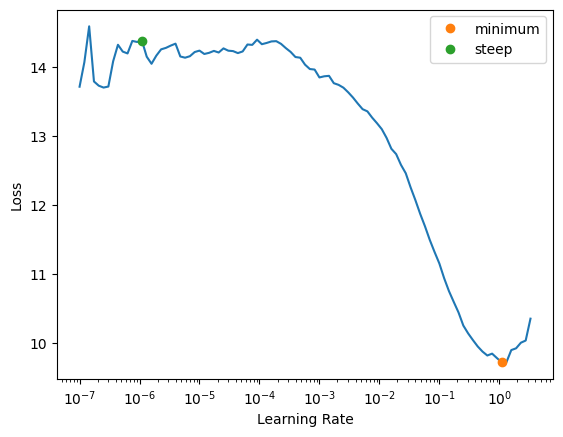

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep))

Train the model:

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,10.024856,5.845850,00:00
1,4.548905,2.830844,00:00
2,2.741005,2.685847,00:00
3,1.774786,2.630414,00:00
4,1.189633,2.668953,00:00


### Predict user ratings for movies:

In [ ]:
# User ID -- The user should already be in the training set or the new user
# should have initial rating values that are used to fine tune the model to include the user preferences for prediction
user_id = 271705

# Creates a list of books that the user has not read.
rated_books = ratings_books_df[ratings_books_df['user'] == user_id]['title'].tolist()
all_books = ratings_books_df['title'].unique().tolist()
unrated_books = [book for book in all_books if book not in rated_books]

# Creates a corresponding list of the user_id, the same size of the list.
users = [user_id] * len(unrated_books)

# Places the two lists into a dataframe.
df = pd.DataFrame({'user': users, 'title': unrated_books})

# Creates a test dataloader.
dl = learn.dls.test_dl(df)

# Gets the rating predictions of each unrated book.
preds, _ = learn.get_preds(dl=dl)  # Unpack the tuple and ignore the second element

# Matches the list of titles and the resulting rating values then sorts and returns the top 10 books.
sorted_preds = sorted(zip(unrated_books, preds.squeeze()), key=lambda x: x[1], reverse=True)
top_recommendations = [pred[0] for pred in sorted_preds[:10]]

print(f"Top 10 book recommendations for user {user_id}:")
for book in top_recommendations:
    print(book)

Top 10 book recommendations for user 271705:
Fahrenheit 451
Harry Potter and the Sorcerer's Stone (Book 1)
Ender's Game (Ender Wiggins Saga (Paperback))
Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson
The Secret Life of Bees
Into the Wild
Harry Potter and the Goblet of Fire (Book 4)
The Two Towers (The Lord of the Rings, Part 2)
The Return of the King (The Lord of the Rings, Part 3)
I Know This Much Is True
